In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh

from utils import general_utils
from utils import visualization_tools
from utils.eval_utils import eval_metrics
#from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [4]:
# displays meshes at the predicted pose
def show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=None, num_novel_view=3,
                metrics_to_eval=["2d_iou_input", "2d_iou_multi", "3d_iou","chamfer_L1"], num_sample_points=900000):
    

    # combining all cached predicted poses
    pred_poses_dict = {}
    pred_pose_paths = list(Path(refined_models_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        pred_poses_dict = {**pred_poses_dict, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(refined_models_dir).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if only_show_instances is None or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
                print(processed_mesh_path)
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                original_mesh_path = os.path.join(input_dir_mesh, instance_name+".obj")
                with torch.no_grad():
                    mesh_original = general_utils.load_untextured_mesh(original_mesh_path, device)
                    mesh_processed = general_utils.load_untextured_mesh(processed_mesh_path, device)
                
                pred_dist = pred_poses_dict[instance_name]['dist']
                pred_elev = pred_poses_dict[instance_name]['elev']
                pred_azim = pred_poses_dict[instance_name]['azim']
                
                # computing performance metrics
                if len(metrics_to_eval) > 0:
                    mesh_original_trimesh = trimesh.load(original_mesh_path)
                    mesh_processed_trimesh = trimesh.load(processed_mesh_path)
                    
                    gt_mesh_path = gt_shapes_dict[instance_name]
                    with torch.no_grad():
                        mesh_gt = general_utils.load_untextured_mesh(gt_mesh_path, device)
                    mesh_gt_trimesh = trimesh.load(gt_mesh_path)
                    
                    metrics_dict_before, _ = eval_metrics(input_image, mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt,
                                                          device, metrics_to_eval, pred_azim, pred_elev, pred_dist, num_sample_points=num_sample_points)
                    metrics_dict_after, _ = eval_metrics(input_image, mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt,
                                                         device, metrics_to_eval, pred_azim, pred_elev, pred_dist, num_sample_points=num_sample_points)
                    
                    print("Metrics before refinement -- {}".format(metrics_dict_before))
                    print("Metrics after refinement -- {}".format(metrics_dict_after))
                
                visualization_tools.show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device, num_novel_view)

In [35]:
# shapenet
class_name = "02691156"
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
#refinement_type = "ablation_1"
#refinement_type = "ablation_2"
#refinement_type = "ablation_3"
#refinement_type = "ablation_4"
refinement_type = "gt_pose"

# regular
input_dir_img = "data/input_images/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# atlasnet
#input_dir_mesh = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/AtlasNet/data/pytorch_3d_render_recs/{}".format(class_name)
#refined_models_dir = "data/refinements/atlasnet/gt_pose/{}".format(class_name)
# pix2mesh
#input_dir_mesh = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
#refined_models_dir = "data/refinements/pix2mesh/gt_pose/{}".format(class_name)
# occnet
input_dir_mesh = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
refined_models_dir = "data/refinements/shapenet_occnet_refinements/{}/{}".format(refinement_type, class_name)

# sym
#input_dir_img  = "data/input_images/asym_pytorch3d_shapenet_renders/{}/rgba".format(class_name)
#input_dir_mesh = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/asym_pytorch3d_renders/{}/generation/meshes".format(class_name)
#refined_models_dir = "data/refinements/asym_shapenet_occnet_refinements/{}/{}".format(refinement_type, class_name)


# pix3d occnet gt
#class_name = "table"
#input_dir_mesh = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_dir_img = "data/input_images/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)
#refined_models_dir = "data/refinements/pix3d_occnet_refinements/gt_pose/{}".format(class_name)

In [6]:
device = torch.device("cuda:0")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]

In [36]:
instances = ['ec68e1edbb7e9bc7e93cebb6ba9ca43e', 'd056e7c8c972455b22a22d22d00874ec', 'dcca76b81c747e76a65e19246f8119cb', 'dd0c4018a8b310edafaeb6535dda1ed', 'd7edd292f614e9dc58b7984178830447', 'd4f8060cf95edeba6ac2b0edda2c907b', 'f4e0c7b0e402ac86e5a953fde71681c', 'daca80d92e046faaaf90989a4df930dd', 'e2a940682bf386d166e77edacd2d5e3a', 'e34d1be103e9d88145a1bc3ecd3d162f', 'd9c11381adf0cf48f1783a44a88d6274', 'fa1e6b0591047eaeef78a907ef09669e', 'd8be4b45afb21cf1616fb9ab42452112', 'ce422cb06b1f372c561f802d2e81cd69', 'f02907c5c42e1e766f1e07a56c129dfc', 'cec8fab8ad62fe3840f3ac0af6b7e700', 'f726fcaa1d031391b2a0fa0a5d25776d', 'e3cc0b06be2c972cab610b0c94236463', 'dd7e82f0ccddf0cdea3769fcd5f96f4', 'ec9d241cddcdb149f5a6ec2a96a47435']
instances = ['ddf4aa5f68f89616bce962d6c4b37336', 'de7cc3442b1775d46559a92f80e3672e', 'e218bb755f35da1bb4cdad9a5bf52dd5', 'eae958f99bad7dcb18b14db3b83de9ff', 'daedff5e78136a8b507c9a5cb0f72e1e', 'd59d75f52ac9b241ae0d772a1c85134a', 'e9b29777e840e1fb63737f7c5d9fc39b', 'fa27e66018f82cf6e549ab640f51dca9', 'dd949574a91719eb7ab25516d117381a', 'd34eba7c2ce4db53adecb6fc00604132', 'ec4a2a47f601397ea01e5c9f53f20fd4', 'dcca40aae3eb0c8757bef59252fb18b5', 'ed2aaca045fb1714cd4229f38ad0d015', 'fcc2023fd98e157f2d99c69702933ca4', 'ddd06628f3bfd0b64e1dedff94c67c76', 'ff12c3a1d388b03044eedf822e07b7e4', 'd5e01850a9d1f3ac5fb48d488d5dfafd', 'ed35478403ae873943cf31d2bcc8f4', 'dd9ece07d4bc696c2bafe808edd44356', 'd438a4539d8068fd44601c64497858af']

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_2_of_3/ed35478403ae873943cf31d2bcc8f4.obj


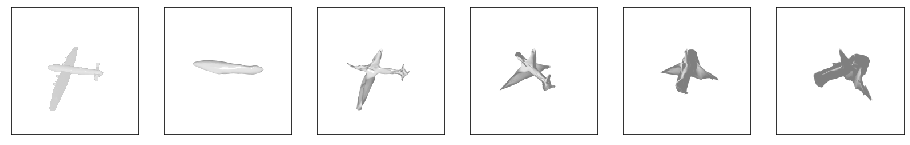

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_2_of_3/e218bb755f35da1bb4cdad9a5bf52dd5.obj


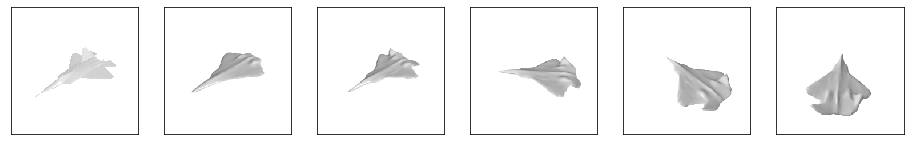

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_2_of_3/ed2aaca045fb1714cd4229f38ad0d015.obj


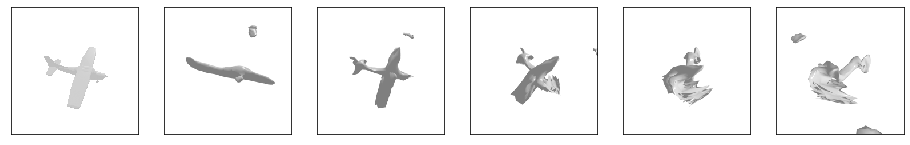

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_2_of_3/eae958f99bad7dcb18b14db3b83de9ff.obj


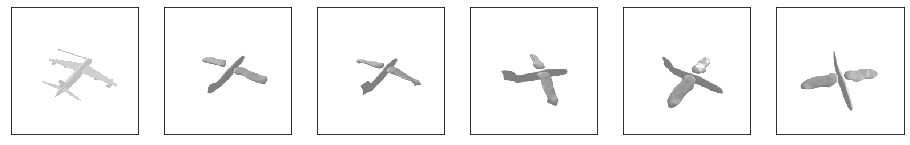

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_2_of_3/e9b29777e840e1fb63737f7c5d9fc39b.obj


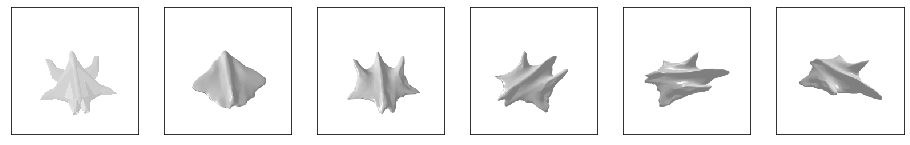

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_2_of_3/ec4a2a47f601397ea01e5c9f53f20fd4.obj


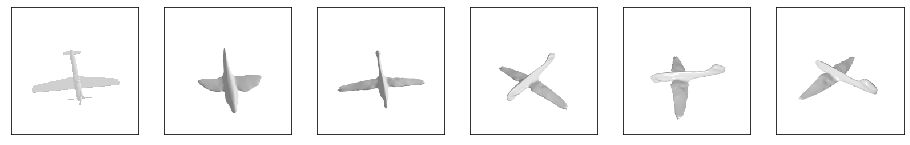

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_3_of_3/fcc2023fd98e157f2d99c69702933ca4.obj


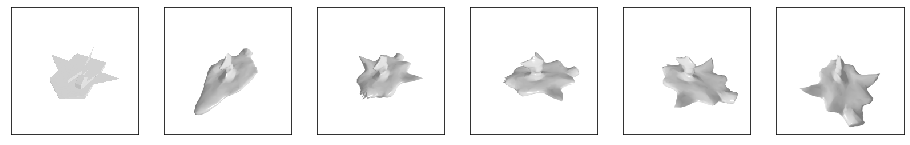

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_3_of_3/fa27e66018f82cf6e549ab640f51dca9.obj


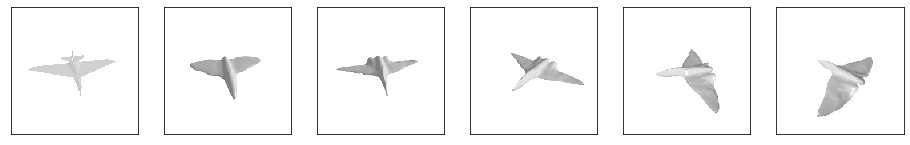

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_3_of_3/ff12c3a1d388b03044eedf822e07b7e4.obj


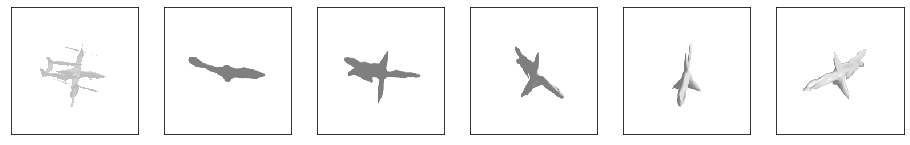

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/de7cc3442b1775d46559a92f80e3672e.obj


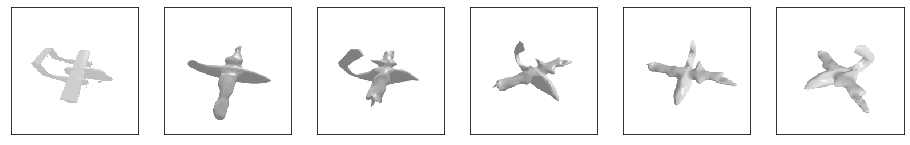

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/dcca40aae3eb0c8757bef59252fb18b5.obj


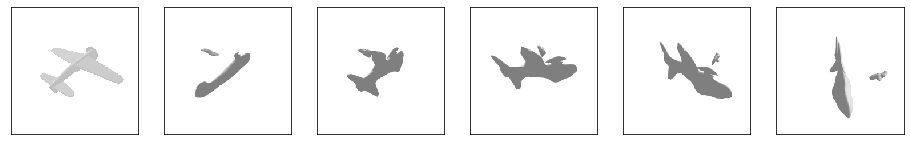

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/d59d75f52ac9b241ae0d772a1c85134a.obj


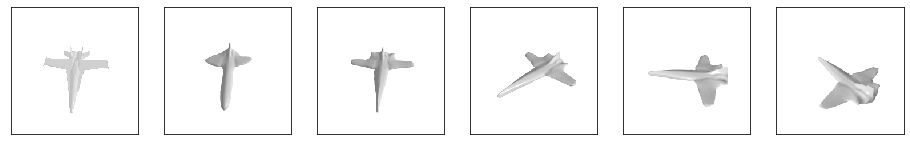

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/d5e01850a9d1f3ac5fb48d488d5dfafd.obj


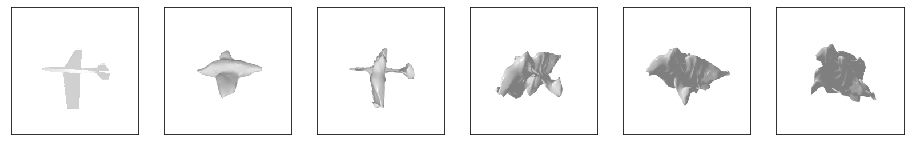

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/ddd06628f3bfd0b64e1dedff94c67c76.obj


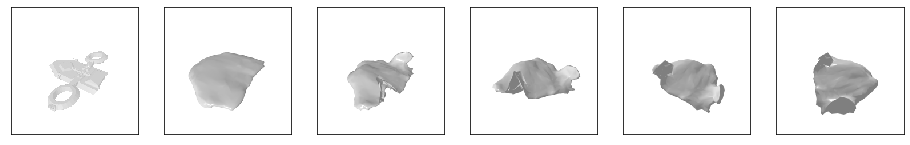

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/dd949574a91719eb7ab25516d117381a.obj


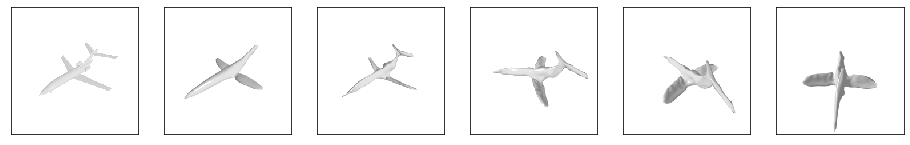

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/dd9ece07d4bc696c2bafe808edd44356.obj


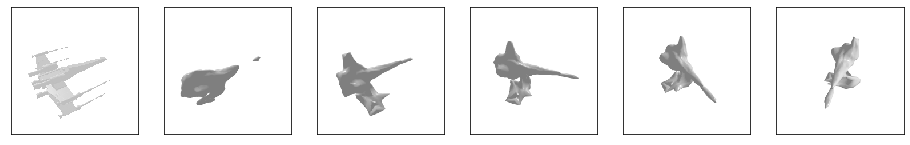

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/d34eba7c2ce4db53adecb6fc00604132.obj


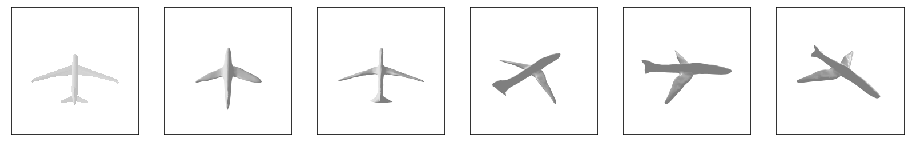

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/daedff5e78136a8b507c9a5cb0f72e1e.obj


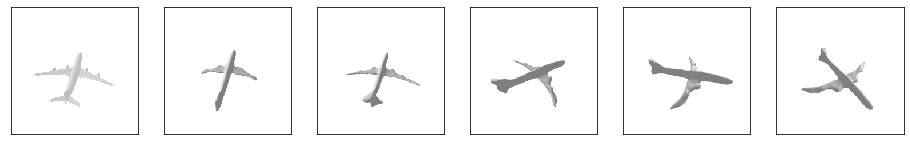

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/d438a4539d8068fd44601c64497858af.obj


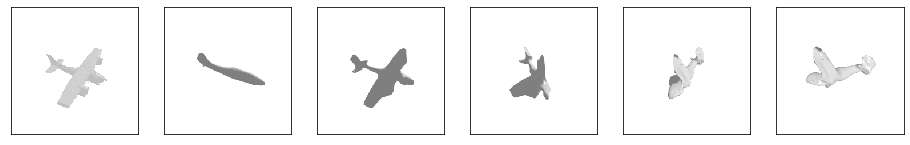

data/refinements/shapenet_occnet_refinements/gt_pose/02691156/batch_1_of_3/ddf4aa5f68f89616bce962d6c4b37336.obj


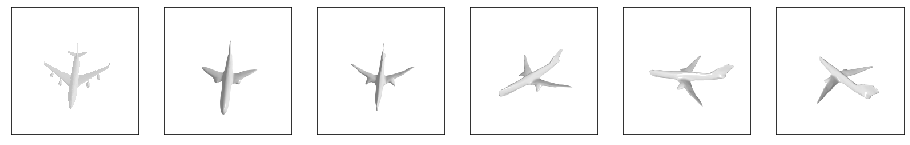

In [37]:
#instances = random.sample([str(path).split('/')[-1].replace('.obj',"") for path in list(Path(refined_models_dir).rglob('*.obj'))], 180)
#instances=None
#instances= ["d2bf5f39131584c0a8cba409c4409ba9", "d3f2dcf27000283799d9d900afe054b8", "d6b4ad58a49bb80cd13ef00338ba8c52", "d532a5abb756ebebcc14f1e6f4f4f49b", "d708c311bcd60e61c9ac656f0c2edc4b", "d722973c75c85d93d0734afa0d357999", "f390b1b28b6dda03dc57b3e43c28d486"]

#m = ["2d_iou_input", "2d_iou_multi", "3d_iou","chamfer_L1"]
m = []
show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=instances, metrics_to_eval=m, num_sample_points=500000)

In [ ]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        #loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        #loss_info.plot.line(x='iteration', y='semantic_dis_loss')